In [1]:
collab_mode =False
import os
os.sys.path


['D:\\iswd_2\\gsn\\laby\\FaceGenerator',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\scripts\\python37.zip',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\DLLs',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\lib',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\scripts',
 'c:\\users\\jakub\\appdata\\local\\programs\\python\\python37\\Lib',
 'c:\\users\\jakub\\appdata\\local\\programs\\python\\python37\\DLLs',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env',
 '',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\lib\\site-packages',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\lib\\site-packages\\win32',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\lib\\site-packages\\win32\\lib',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\lib\\site-packages\\Pythonwin',
 'd:\\iswd_2\\gsn\\laby\\facegenerator\\env\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Jakub\\.ipython']

In [3]:
if collab_mode:
    # set up tensorflow
    %tensorflow_version 2.x
# imports
import tensorflow as tf
import tensorflow_datasets as tfds
# tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt

import warnings # This ignore all the warning messages
warnings.filterwarnings('ignore')

from os import path
import time

print(tf.__version__)

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
root_local_path = ''
root_gdrive_path = '/content/drive'
gdrive_project_path = 'My Drive/pp/GSN/FaceGenerator'
checkpoints_path = 'checkpoints'
dataset_path = 'datasets'
tensorboard_logs_dir='tensorboard'
download_path = '' # output path for the dataset
generated_images_path = 'generated_images'
dataset_image_size = (28, 28)
run_name = ''
gdrive_mounted = False

In [8]:
import math
import os
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm


def _read32(bytestream):
    """
    Read 32-bit integer from bytesteam
    :param bytestream: A bytestream
    :return: 32-bit integer
    """
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)


def _ungzip(save_path, extract_path, database_name, _):
    """
    Unzip a gzip file and extract it to extract_path
    :param save_path: The path of the gzip files
    :param extract_path: The location to extract the data to
    :param database_name: Name of database
    :param _: HACK - Used to have to same interface as _unzip
    """
    # Get data from save_path
    with open(save_path, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            if magic != 2051:
                raise ValueError('Invalid magic number {} in file: {}'.format(magic, f.name))
            num_images = _read32(bytestream)
            rows = _read32(bytestream)
            cols = _read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)

    # Save data to extract_path
    for image_i, image in enumerate(
            tqdm(data, unit='File', unit_scale=True, miniters=1, desc='Extracting {}'.format(database_name))):
        Image.fromarray(image, 'L').save(os.path.join(extract_path, 'image_{}.jpg'.format(image_i)))


def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))


def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch


def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im


def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_CELEBA_NAME = 'celeba'
    DATASET_MNIST_NAME = 'mnist'

    if database_name == DATASET_CELEBA_NAME:
        url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
        hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
        extract_path = os.path.join(data_path, 'img_align_celeba')
        save_path = os.path.join(data_path, 'celeba.zip')
        extract_fn = _unzip
  
    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    # Remove compressed data
    os.remove(save_path)


class Dataset(object):
    """
    Dataset
    """
    def __init__(self, dataset_name, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        if dataset_name == DATASET_CELEBA_NAME:
            self.image_mode = 'RGB'
            image_channels = 3

        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5


class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [6]:
def allow_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

# run the line below if you're using local runtime and have GTX > 1660 (this is known bug with tensorflow memory allocation)
# allow_memory_growth()

print("Getting device name")
tf.test.gpu_device_name()

Getting device name


'/device:GPU:0'

Misc helper functions

In [7]:
def get_time():
    return time.strftime("%Y-%m-%d_%H:%M:%S") 

# Mount gdrive disk if necessary

In [9]:
if collab_mode:
    from google.colab import drive
    project_path = path.join(root_gdrive_path, gdrive_project_path )
    gdrive_project_path = path.join(root_gdrive_path, gdrive_project_path)
    drive.mount(root_gdrive_path)
    gdrive_mounted = True

def get_base_path():
    if collab_mode:
        return path.join(root_gdrive_path, gdrive_project_path)
    else:
        return root_local_path 

Dataset helpers


In [10]:
def load_dataset():
    '''Should return train data'''
    
    dataset_name = "celeb_a"
    if collab_mode:
        download_path = path.join(root_gdrive_path, gdrive_project_path, dataset_path, dataset_name)
    else:
        download_path = path.join(root_local_path, dataset_path, dataset_name)
    
    print('dataset download path is {}'.format(download_path))
    
    download_extract('celeba', download_path)
    # data_train = tfds.load(name=dataset_name,
    #                       split="train",
    #                       data_dir=download_path)
    # return data_train

load_dataset()


dataset download path is datasets\celeb_a


AssertionError: datasets\celeb_a\celeba.zip file is corrupted.  Remove the file and try again.

In [16]:
download_path = path.join(root_local_path, dataset_path, 'celeb_a')
img_path = path.join(download_path, '1k\\*.jpg')
print(img_path)
data = tf.data.Dataset.list_files(
    img_path,
    seed=101
)


datasets\celeb_a\1k\*.jpg


NotFoundError: FindFirstFile failed for: datasets/celeb_a/1k : The system cannot find the path specified.
; No such process [Op:MatchingFiles]

In [ ]:
print(data)


In [0]:
def process_dataset(images, labels, buffer_size, batch_size):
    x, y = dataset_image_size
    images = images.reshape(images.shape[0], y, x, 3).astype('float32')
    images = (images - 127.5) / 127.5
    labels = labels.astype('int32')
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))\
        .shuffle(buffer_size)\
        .batch(batch_size)
    return dataset

def save_generated_image(epoch):
    name = path.join(get_root_path(),
                     generated_images_path,
                     run_name,
                     'img_{}_{}.png'.format(epoch, get_time()))
    plt.savefig(name)

def show_images(images, epoch, img_size=12, save_images=False):
    fig = plt.figure(figsize=(img_size, img_size * 10))

    for i in range(images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(images[i, :, :, :] * 127.5 + 127.5)
        plt.axis('off')

    if save_images:
        save_generated_image(epoch)
    plt.show()

In [0]:
def save_models(generator, discriminator):
    def save(epoch_number):
        path = get_path()
    return save

In [1]:
%reload_ext  tensorboard
log_dir_path = path.join(get_base_path(), tensorboard_logs_dir)
print('tensorboard log dir {}'.format(log_dir_path))
%tensorboard --logdir log_dir_path
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

NameError: ignored

Loss functions


In [0]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def min_max_discriminator_loss(real_out, gen_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    gen_loss = bce(tf.zeros_like(gen_out), gen_out)
    return real_loss + gen_loss


def min_max_generator_loss(gen_out):
    return - min_max_discriminator_loss(tf.ones_like(gen_out), gen_out)


def w_discriminator_loss(real_out, gen_out):
    return - (tf.reduce_mean(real_out) - tf.reduce_mean(gen_out))


def w_generator_loss(gen_out):
    return - tf.reduce_mean(gen_out)

Generator


In [0]:
class Generator(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.noise_decoder = tf.keras.Sequential([
        # flat      
        tf.keras.layers.Dense(7*7*3*256, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape([7, 7, 3, 256]),
        # conv without stride (7x7)
        tf.keras.layers.Conv3D(128, 5, 1, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # t_conv with stride (14x14)
        tf.keras.layers.Conv3DTranspose(64, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # conv without stride (14x14)
        tf.keras.layers.Conv3D(32, 5, 1, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # t_conv with stride (28x28)
        tf.keras.layers.Conv3DTranspose(32, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # conv without stride
        tf.keras.layers.Conv3D(1, 5, 1, 'same')
    ])

  def call(self, noise, training):
    return self.noise_decoder(noise)

Discriminator


In [0]:
class Discriminator(tf.keras.Model):

  def __init__(self):
    super().__init__()

    # since discriminator is for classification it should be robust, thus, add
    # additional regularization like dropout to prevent from pixel attacks
    self.image_encoder = tf.keras.Sequential([
        # conv with stride (out = 14x14)
        tf.keras.layers.Conv3D(64, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.3),
        # conv with stride (out = 7x7)
        tf.keras.layers.Conv3D(128, 3, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.3),
        # flatten + hidden layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.3),
        # prediction (LOGITS!)
        tf.keras.layers.Dense(1)
    ])

  def call(self, images, training):
    return self.image_encoder(images)

Noise generator


In [0]:
class NoiseGenerator(tf.keras.layers.Layer):

  def __init__(self, num_classes, distribution_size):
    super().__init__()
    self.distribution_size = distribution_size
    # self.data_distributions = self.add_weight(shape=(num_classes, distribution_size), trainable=True)
    # self.data_distributions = tf.tile(tf.range(0, num_classes, dtype=tf.float32)[:, tf.newaxis], [1, distribution_size])
    # TODO:

  def call(self, inputs):
    # dists = tf.nn.embedding_lookup(self.data_distributions, inputs)
    # dists += tf.random.uniform(tf.shape(dists), -0.35, 0.35)
    # return dists
    # TODO
    return tf.random.uniform([tf.shape(inputs)[0], self.distribution_size])

  def diverse_distributions_loss(self):
    # TODO
    return None

Training step



In [0]:
def train_step_template(generator, discriminator, noise, d_optim, g_optim, d_loss_f, g_loss_f):

  @tf.function
  def _train_step_template(images, labels):
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      real_out = discriminator(images, True)
      gen_out = discriminator(generator(noise(labels), True), True)

      d_loss = d_loss_f(real_out, gen_out)
      g_loss = g_loss_f(gen_out)
    
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables + noise.trainable_variables)

    d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    g_optim.apply_gradients(zip(g_grads, generator.trainable_variables + noise.trainable_variables))
  
  return _train_step_template


Inference step



In [0]:
def gen_step_template(generator, noise):

  @tf.function
  def _gen_step_template(labels):
    return tf.clip_by_value(generator(noise(labels), False), -1, 1)

  return _gen_step_template

Training

In [0]:
def train(train_step, gen_step, epochs, batch_size, train_data, save_images=True):
  train_ds = process_dataset(*train_data, 60000, batch_size)
  run_name = 'run_{}'.format(get_time())

  for epoch in range(epochs):

    for images, labels in train_ds:
      train_step(images, labels)
    
    print('Epoch {0}/{1}'.format(epoch, epochs))

    images = gen_step([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    show_images(images, epoch, save_images=save_images)

    

Training with Wasserstein loss function

In [33]:
generator = Generator()
discriminator = Discriminator()
print(generator.summary())


ValueError: ignored

11493376/11490434 [==============================] - 0s 0us/step
Epoch 0/30


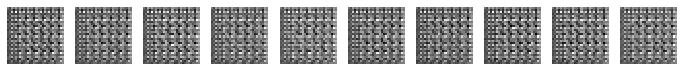

Epoch 1/30


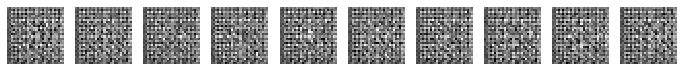

Epoch 2/30


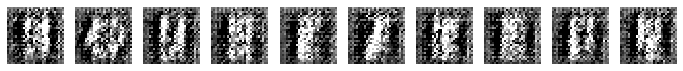

Epoch 3/30


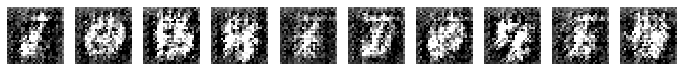

Epoch 4/30


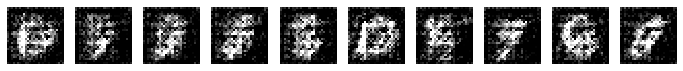

Epoch 5/30


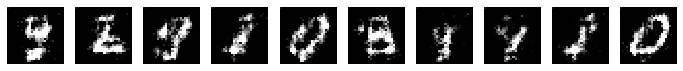

Epoch 6/30


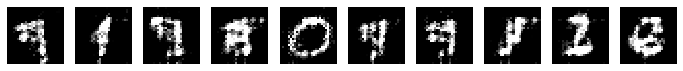

Epoch 7/30


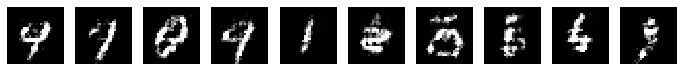

Epoch 8/30


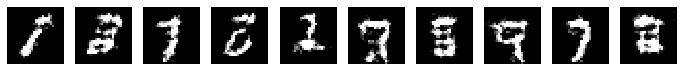

Epoch 9/30


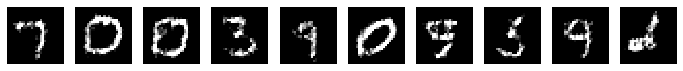

Epoch 10/30


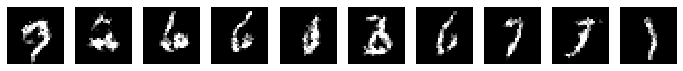

Epoch 11/30


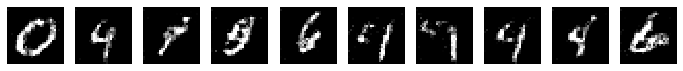

Epoch 12/30


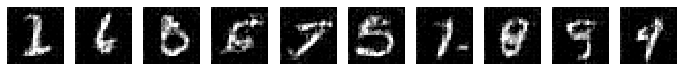

Epoch 13/30


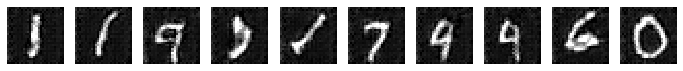

Epoch 14/30


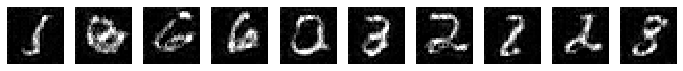

Epoch 15/30


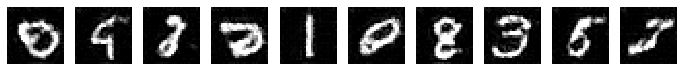

Epoch 16/30


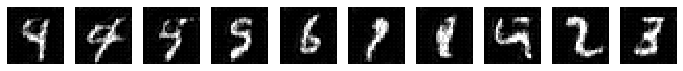

Epoch 17/30


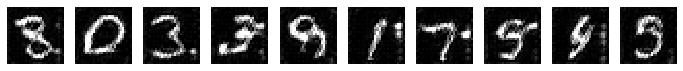

Epoch 18/30


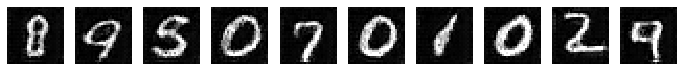

Epoch 19/30


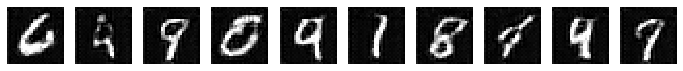

Epoch 20/30


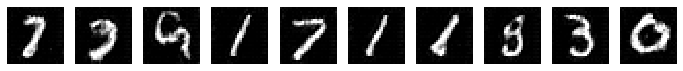

Epoch 21/30


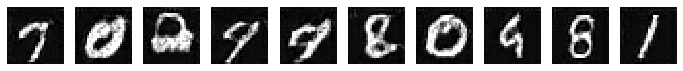

Epoch 22/30


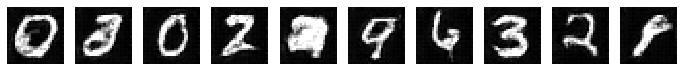

Epoch 23/30


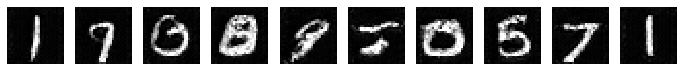

Epoch 24/30


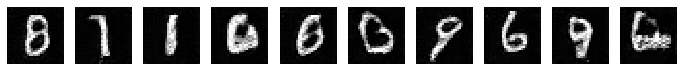

Epoch 25/30


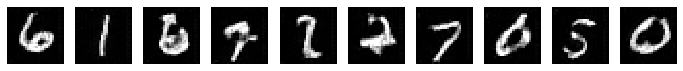

Epoch 26/30


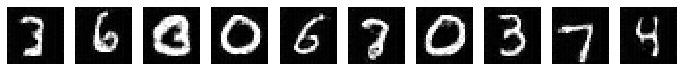

Epoch 27/30


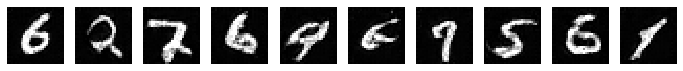

Epoch 28/30


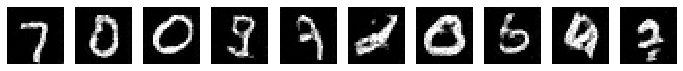

Epoch 29/30


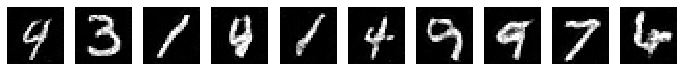

In [0]:
generator = Generator()
discriminator = Discriminator()
noise = NoiseGenerator(10, 64)
d_optim = tf.optimizers.Adam(1e-4)
g_optim = tf.optimizers.Adam(1e-4)

train_data = get_dataset()

train_step = train_step_template(
    generator=generator,
    discriminator=discriminator,
    noise=noise,
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_f=w_discriminator_loss,
    g_loss_f=w_generator_loss,
)

gen_step = gen_step_template(
    generator=generator,
    noise=noise
)

train(
    train_step=train_step, 
    gen_step=gen_step, 
    epochs=30,
    batch_size=256,
    train_data=train_data
)

In [0]:
# save model - download required packages
!pip install -q pyyaml h5py  # Required to save models in HDF5 format


In [0]:
from tensorflow import keras

print(tf.version.VERSION)


2.0.0


In [0]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    multiple                  879873    
Total params: 879,873
Trainable params: 879,233
Non-trainable params: 640
_________________________________________________________________
